<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 4 Lesson 3*

# Generative Adversarial Networks (GANs)


*PS: The person below does not exist*


<img src="https://thispersondoesnotexist.com/image" width=500>

# Lecture

Learning Objectives:
1. What is a GAN?
    - Describe the mechanisms of a Generator & Discriminator
    - Describe the Adverserial process
2. How does a GAN achieve good results?
    - Talk about relationship with Game Theory 
    - Illustrate NASH equilibrium

## GAN Overview
<img  src="https://github.com/Jeffrowetull/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module3-generative-adversarial-networks/GAN%20Overview.jpeg?raw=1" width=800>

<br></br>
<br></br>
<br></br>

## GAN Framework
<img  src="https://github.com/Jeffrowetull/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module3-generative-adversarial-networks/GAN%20Framework.jpeg?raw=1" width=800>

## *Two* neural networks - adversaries!

![Spy vs. Spy](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg/360px-Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg)

Generative Adversarial Networks is an approach to unsupervised learning, based on the insight that we can train *two* networks simultaneously and pit them against each other.

- The discriminator is trained with real - but unlabeled - data, and has the goal of identifying whether or not some new item belongs in it.
- The generator starts from noise (it doesn't see the data at all!), and tries to generate output to fool the discriminator (and gets to update based on feedback).

GANs can be considered a zero-sum game, in the [game theory](https://en.wikipedia.org/wiki/Game_theory) sense. Game theory is a common approach to modeling strategic competitive behavior between rational decision makers, and is heavily used in economics as well as computer science.

If you've also heard the hype about [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), one way to understand it is:

```
Reinforcement Learning : GAN :: Decision Theory : Game Theory
```

That is, Reinforcement Learning is more closely analogous to [decision theory](https://en.wikipedia.org/wiki/Decision_theory), a relative to the field of game theory, featuring the behavior of an "agent" against "nature" (the environment). The agent is strategic and rational, but the environment simply is.

## A Foray into Game Theory

What is a "zero sum" game? It is a model of the interaction of two strategic agents, in a situation where, for one to gain, the other must lose, and vice-versa.

A famous example is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma). The typical story behind this game is something like this:

> Two criminals who committed a crime together are caught by the authorities. There is enough evidence to put them each away for 3 years, but the police interrogate them separately, and offer each of them a deal - "Tell us what the other criminal did, and we'll go lighter on you."

> The deal is tempting - the person who takes it shaves 2 years off their sentence. But, it adds 5 years to the sentence of the other person. So if both talk, they both get 3 - 2 + 5 = 6 years, twice as much if they both don't. But if one talks and the other doesn't, the talker gets 1 year and the non-talker gets 8!

> The result is, individually, they both prefer defecting (talking with the police) regardless of what the other person does. But, they'd both be better off if they could somehow trust one another to not talk to the police.

Mathematically, we consider this outcome a *Nash equilibrium* - a stable situation where neither player would want to unilaterally change strategy. But, it's one where a *pareto superior* outcome exists (an outcome that both players would prefer to what they have now).

An illustration (with different numbers) of the Prisoner's Dilemma:

![Prisoner's Dilemmat](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Dilema_do_Prisioneiro.png/480px-Dilema_do_Prisioneiro.png)

More generally, these could be referred to as "constant sum" games - "zero sum" implies that for any player to get ahead, the other must inevitably end up behind. The above illustration could be of a game where people are "splitting loot", and so everybody *gets* something - it's just that some get more than others. The utility can be normalized so it sums to zero, or any other constant.

Game Theory is one of the core tools used in social science and other areas to model and explain behavior. The main path to overcome "dilemmas" is *iteration* - through repetition, players can have a reputation, and value that reputation more than the outcome in any single round. For example, think of the lengths some restaurants take to ensure positive reviews.

*Exercise* - think of at least two scenarios that could be explained with Prisoner's Dilemma, and of one other scenario that you think could also be modeled as some sort of strategic game between agents.

## Minimum Viable GAN

Courtesy of Keras:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [0]:
np.random.seed(10)
random_dim = 100
 
def load_minst_data():
    # load the data - we'll use Fashion MNIST, for a change of pace
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [0]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

4423680/4422102 [==============================] - 0s 0us/step


W0724 16:06:09.692301 140496933046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 16:06:09.694701 140496933046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 16:06:09.697122 140496933046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0724 16:06:09.723123 140496933046144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 16:06:09.774244 140496933046144 deprecation_wra

--------------- Epoch 1 ---------------


  1%|          | 6/937 [00:00<00:17, 51.94it/s]

--------------- Epoch 2 ---------------


  1%|          | 6/937 [00:00<00:17, 52.53it/s]

--------------- Epoch 3 ---------------


  1%|          | 6/937 [00:00<00:17, 53.43it/s]

--------------- Epoch 4 ---------------


  1%|          | 6/937 [00:00<00:17, 52.47it/s]

--------------- Epoch 5 ---------------


  1%|          | 6/937 [00:00<00:17, 53.86it/s]

--------------- Epoch 6 ---------------


  1%|          | 6/937 [00:00<00:17, 54.09it/s]

--------------- Epoch 7 ---------------


  1%|          | 6/937 [00:00<00:17, 53.49it/s]

--------------- Epoch 8 ---------------


  1%|          | 6/937 [00:00<00:17, 52.86it/s]

--------------- Epoch 9 ---------------


  1%|          | 6/937 [00:00<00:17, 54.07it/s]

--------------- Epoch 10 ---------------


  1%|          | 6/937 [00:00<00:18, 50.80it/s]

--------------- Epoch 11 ---------------


  1%|          | 6/937 [00:00<00:17, 52.35it/s]

--------------- Epoch 12 ---------------


  1%|          | 6/937 [00:00<00:17, 52.75it/s]

--------------- Epoch 13 ---------------


  1%|          | 6/937 [00:00<00:17, 54.35it/s]

--------------- Epoch 14 ---------------


  1%|          | 6/937 [00:00<00:17, 52.63it/s]

--------------- Epoch 15 ---------------


  1%|          | 6/937 [00:00<00:17, 53.97it/s]

--------------- Epoch 16 ---------------


  1%|          | 6/937 [00:00<00:17, 54.13it/s]

--------------- Epoch 17 ---------------


  1%|          | 6/937 [00:00<00:17, 52.65it/s]

--------------- Epoch 18 ---------------


  1%|          | 6/937 [00:00<00:17, 52.08it/s]

--------------- Epoch 19 ---------------


  1%|          | 5/937 [00:00<00:18, 49.63it/s]

--------------- Epoch 20 ---------------


  1%|          | 6/937 [00:00<00:18, 50.76it/s]

--------------- Epoch 21 ---------------


  1%|          | 6/937 [00:00<00:17, 54.17it/s]

--------------- Epoch 22 ---------------


  1%|          | 6/937 [00:00<00:17, 54.18it/s]

--------------- Epoch 23 ---------------


  1%|          | 6/937 [00:00<00:17, 54.17it/s]

--------------- Epoch 24 ---------------


  1%|          | 5/937 [00:00<00:19, 48.35it/s]

--------------- Epoch 25 ---------------


  1%|          | 6/937 [00:00<00:17, 53.60it/s]

--------------- Epoch 26 ---------------


  1%|          | 6/937 [00:00<00:17, 53.40it/s]

--------------- Epoch 27 ---------------


  1%|          | 6/937 [00:00<00:17, 51.79it/s]

--------------- Epoch 28 ---------------


  1%|          | 6/937 [00:00<00:17, 54.03it/s]

--------------- Epoch 29 ---------------


  1%|          | 6/937 [00:00<00:17, 53.33it/s]

--------------- Epoch 30 ---------------


  1%|          | 6/937 [00:00<00:17, 52.23it/s]

--------------- Epoch 31 ---------------


  1%|          | 6/937 [00:00<00:18, 51.61it/s]

--------------- Epoch 32 ---------------


  1%|          | 6/937 [00:00<00:18, 51.14it/s]

--------------- Epoch 33 ---------------


  1%|          | 6/937 [00:00<00:17, 54.13it/s]

--------------- Epoch 34 ---------------


  1%|          | 6/937 [00:00<00:17, 52.63it/s]

--------------- Epoch 35 ---------------


  1%|          | 6/937 [00:00<00:17, 52.29it/s]

--------------- Epoch 36 ---------------


  1%|          | 6/937 [00:00<00:17, 52.21it/s]

--------------- Epoch 37 ---------------


  1%|          | 6/937 [00:00<00:17, 53.10it/s]

--------------- Epoch 38 ---------------


  1%|          | 5/937 [00:00<00:19, 48.91it/s]

--------------- Epoch 39 ---------------


  1%|          | 6/937 [00:00<00:17, 53.15it/s]

--------------- Epoch 40 ---------------


100%|██████████| 937/937 [00:17<00:00, 52.49it/s]


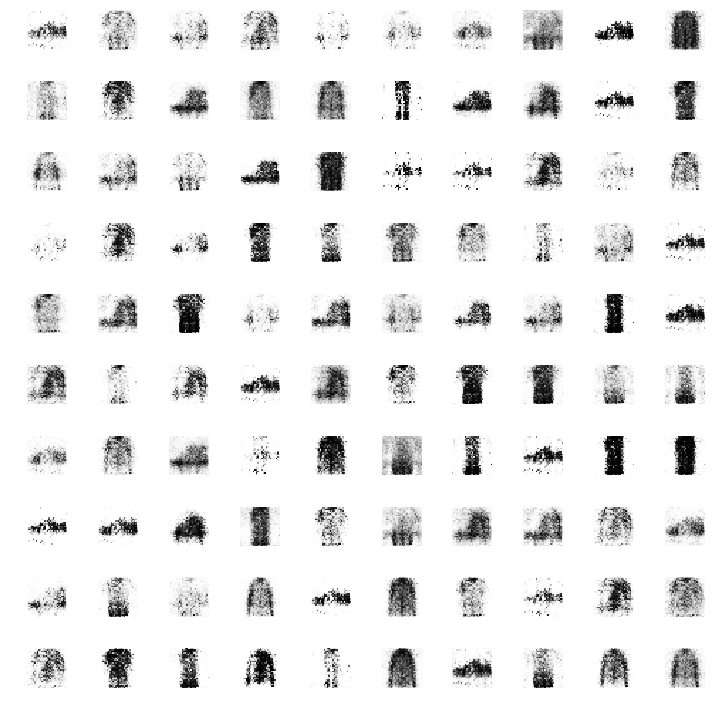

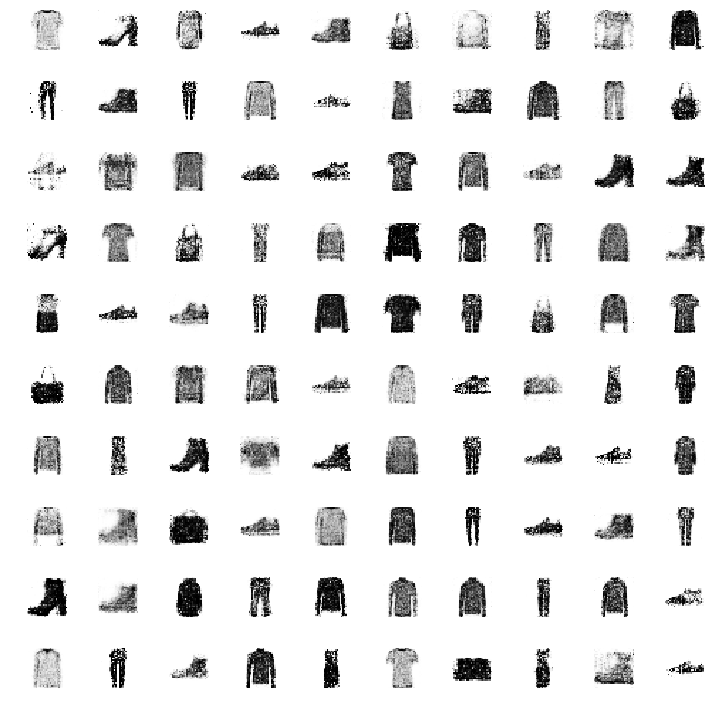

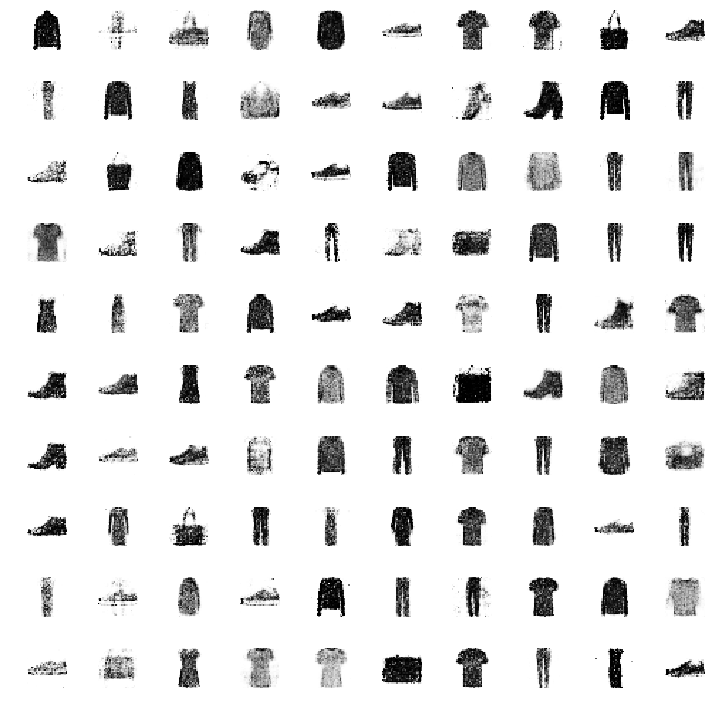

In [4]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
 
train(40, 64)

Pretty decent results, even after not too many iterations.

We can do even better, with pretrained StyleGAN!

## StyleGAN - A Style-Based Generator Architecture for Generative Adversarial Networks

Original paper: https://arxiv.org/abs/1812.04948

Source code: https://github.com/NVlabs/stylegan

Many applications:
- https://thispersondoesnotexist.com
- https://thiscatdoesnotexist.com
- https://thisairbnbdoesnotexist.com
- https://stackroboflow.com

In [5]:
!git clone https://github.com/NVlabs/stylegan
%cd stylegan/

Cloning into 'stylegan'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.
/content/stylegan


In [0]:
# From stylegan/pretrained_example.py

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

def main():
    # Initialize TensorFlow.
    tflib.init_tf()

    # Load pre-trained network.
    url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
    with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
        _G, _D, Gs = pickle.load(f)
        # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
        # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
        # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

    # Print network details.
    Gs.print_layers()

    # Pick latent vector.
    rnd = np.random.RandomState(5)
    latents = rnd.randn(1, Gs.input_shape[1])

    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

    # Save image.
    os.makedirs(config.result_dir, exist_ok=True)
    png_filename = os.path.join(config.result_dir, 'example.png')
    PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

main()

In [0]:
from IPython.display import Image
Image(filename='results/example.png')

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [0]:
!pip install emoji_data_python

In [0]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

In [0]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [12]:
example_emoji.shape

(28, 28, 4)

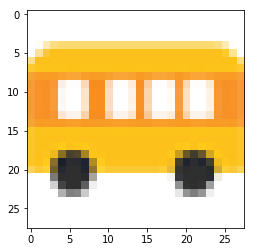

In [13]:
plt.imshow(example_emoji);

In [14]:
grayscale_emoji.shape

(28, 28)

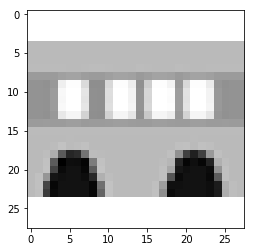

In [15]:
plt.imshow(grayscale_emoji, cmap="gray");

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import tensorflow as tf
print(tf.__version__)

In [0]:
!pip install tensorflow_gpu==2.0.0-alpha0

In [0]:
!pip install -q imageio

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf

tf.__version__

'2.0.0-alpha0'

In [45]:
'''Hint - the main challenge in getting an MVP running will just be loading and converting all the images.
os.listdir plus a loop, and refactoring the image processing code into a function, should go a long way.'''

train_images = []

for file in os.listdir('/content/stylegan/emoji'):
  
  train_images.append(file)
print(len(train_images))

861


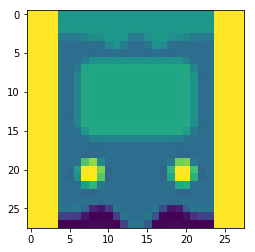

In [109]:
import imageio
from skimage import color

images = glob.glob('/content/stylegan/emoji/*.png')
train_images=[]
for image in images:
    with open(image, 'rb') as file:
        img = imageio.imread(file)
        
        grey_img = color.rgb2gray(img)
        plt.imshow(grey_img)
        
        train_images.append(np_img)

In [0]:
train_images = np.array(train_images)

In [0]:
def load_emoji_data():
    
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (train_images.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(861, 28,28,1)
    return (x_train)

In [0]:
train_images = load_emoji_data()

In [71]:
train_images.shape

(861, 28, 28, 1)

In [0]:
BUFFER_SIZE = 861
BATCH_SIZE = 64

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256)
  
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same',
                                   use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same',
                                   use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same',
                                   use_bias=False))
  assert model.output_shape == (None, 28, 28, 1)
  
  return model

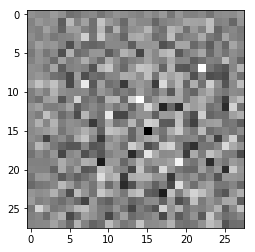

In [86]:
generator = make_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

#Discriminate

In [0]:
def make_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                          input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  
  return model

In [88]:
discriminator = make_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-3.5042118e-05]], shape=(1, 1), dtype=float32)


###Loss

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
#checkpoints!
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:
epochs = 1000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


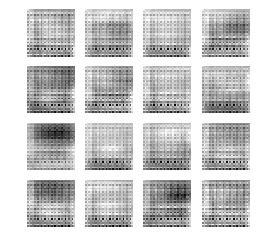

CPU times: user 22min 34s, sys: 5min 36s, total: 28min 11s
Wall time: 26min 4s


In [98]:
%%time
train(train_dataset, epochs)


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


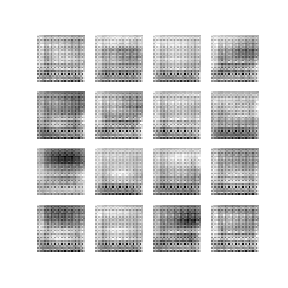

In [101]:
display_image(epochs)


In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)


In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)


# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji